# TP1: Metodología Box-Jenkins y Suavizado Exponencial ETS

# 1. Configuración inicial y carga de datos

### 1.1 Instalación y carga de librerías

In [37]:
# Instalar paquetes si no están disponibles
# if(!require(readxl)) install.packages("readxl")
# if(!require(forecast)) install.packages("forecast")
# if(!require(tseries)) install.packages("tseries")
# if(!require(ggplot2)) install.packages("ggplot2")
# if(!require(dplyr)) install.packages("dplyr")
# if(!require(zoo)) install.packages("zoo")

# Cargar librerías necesarias
library(readxl)
library(forecast)
library(tseries)
library(ggplot2)
library(dplyr)
library(zoo)

# Definir ruta del proyecto
project_path <- "C:/Users/trico/OneDrive/UBA/Series de tiempo/TP1"

# 2.1) Cargar función de diagnóstico de residuos
source(file.path(project_path, "corr_res.R"))

# Configurar opciones
options(scipen = 999)  # Evitar notación científica
par(bg = "white")      # Fondo blanco para gráficos base

### 1.2 Lectura de datos

In [38]:
# Leer datos de Argentina (skip=1 para eliminar sólo el título)
datos_arg <- read_excel(
  file.path(project_path, "Datos Argentina.xlsx"),
  skip      = 1,
  col_names = c("Periodo","EMAE","IPC","M2N","M2R","TASA")
)

# Leer datos de Chile (skip=3 para saltar título, línea en blanco y cabecera)
datos_chi <- read_excel(
  file.path(project_path, "Datos Chile.xlsx"),
  skip      = 3,
  col_names = c("Periodo","IMACEC","M2N","IPC","M2R","TASA")
)

# Mostrar primeras filas para verificar
head(datos_arg, 5)
head(datos_chi, 5)

Periodo,EMAE,IPC,M2N,M2R,TASA
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004M01,98.44894,77.33982,66006023,66006023,4.57
2004M02,98.17701,77.18623,67545780,67680182,4.03
2004M03,97.80754,77.32858,68027349,68037235,3.69
2004M04,95.04287,77.62270,70499728,70242804,3.48
2004M05,96.89273,77.75169,72987490,72600858,3.54


Periodo,IMACEC,M2N,IPC,M2R,TASA
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004-01-01,56.95508,22880.17,46.12519,22880.17,6.107525
2004-02-01,54.85665,22853.76,46.12926,22851.74,6.407674
2004-03-01,61.86300,23231.16,46.32336,23131.78,6.943765
2004-04-01,60.63709,23852.51,46.49362,23663.49,6.637812
2004-05-01,60.08506,23705.82,46.73653,23395.73,6.957272


# 2. Preparación de series temporales



### 2.1 Creación de series temporales y diferencias logarítmicas

In [39]:
datos_arg$Fecha <- as.Date(as.yearmon(gsub("M","-", datos_arg$Periodo), "%Y-%m"))
datos_chi$Fecha <- as.Date(as.numeric(datos_chi$Periodo), origin="1899-12-30")

# Crear objetos ts (enero-2004 en adelante)
ts_emae     <- ts(datos_arg$EMAE,     start=c(2004,1), frequency=12)
ts_ipc_arg  <- ts(datos_arg$IPC,      start=c(2004,1), frequency=12)
ts_m2_arg   <- ts(datos_arg$M2N,      start=c(2004,1), frequency=12)
ts_tasa_arg <- ts(datos_arg$TASA,     start=c(2004,1), frequency=12)

ts_imacec   <- ts(datos_chi$IMACEC,   start=c(2004,1), frequency=12)
ts_ipc_chi  <- ts(datos_chi$IPC,      start=c(2004,1), frequency=12)
ts_m2_chi   <- ts(datos_chi$M2N,      start=c(2004,1), frequency=12)
ts_tasa_chi <- ts(datos_chi$TASA,     start=c(2004,1), frequency=12)

In [40]:
# Calcular diferencias logarítmicas de cada serie temporal previamente creada

# Función para calcular la diferencia logarítmica 
# (aproxima la tasa de crecimiento)
calcular_diff_log <- function(x) diff(log(x))

# --- Series de Argentina ---
# Dif. log EMAE (Act. Económica) Arg
dl_emae     <- calcular_diff_log(ts_emae)     
# Dif. log IPC (Precios) Arg
dl_ipc_arg  <- calcular_diff_log(ts_ipc_arg)  
# Dif. log M2 (Agregado Monetario) Arg
dl_m2_arg   <- calcular_diff_log(ts_m2_arg)   
# Dif. log TASA (Interés) Arg
dl_tasa_arg <- calcular_diff_log(ts_tasa_arg) 

# --- Series de Chile ---
# Dif. log IMACEC (Act. Económica) Chi
dl_imacec   <- calcular_diff_log(ts_imacec)   
# Dif. log IPC (Precios) Chi
dl_ipc_chi  <- calcular_diff_log(ts_ipc_chi)  
# Dif. log M2 (Agregado Monetario) Chi
dl_m2_chi   <- calcular_diff_log(ts_m2_chi)   
# Dif. log TASA (Interés) Chi
dl_tasa_chi <- calcular_diff_log(ts_tasa_chi) 

# Definir ventanas de entrenamiento para cada serie diferenciada
# Período de entrenamiento: hasta diciembre 2022

# --- Ventanas de Entrenamiento - Argentina ---
# EMAE Arg (entrenamiento)
dl_emae_train     <- window(dl_emae,     end = c(2022, 12)) 
# IPC Arg (entrenamiento)
dl_ipc_arg_train  <- window(dl_ipc_arg,  end = c(2022, 12)) 
# M2 Arg (entrenamiento)
dl_m2_arg_train   <- window(dl_m2_arg,   end = c(2022, 12)) 
# TASA Arg (entrenamiento)
dl_tasa_arg_train <- window(dl_tasa_arg, end = c(2022, 12)) 

# --- Ventanas de Entrenamiento - Chile ---
# IMACEC Chi (entrenamiento)
dl_imacec_train   <- window(dl_imacec,   end = c(2022, 12)) 
# IPC Chi (entrenamiento)
dl_ipc_chi_train  <- window(dl_ipc_chi,  end = c(2022, 12)) 
# M2 Chi (entrenamiento)
dl_m2_chi_train   <- window(dl_m2_chi,   end = c(2022, 12)) 
# TASA Chi (entrenamiento)
dl_tasa_chi_train <- window(dl_tasa_chi, end = c(2022, 12)) 

# 3. Estimacion de modelos

## Argentina

### 3.1 Estimacion EMAE - Arg

In [41]:
# --- Forzar estructura de IMACEC Chile (ARIMA(4,0,0)(0,1,1)[12]) a EMAE Argentina ---
# Objetivo: Aplicar manualmente la estructura que funcionó razonablemente bien
#           para IMACEC Chile a la serie EMAE Argentina, para ver si mejora
#           el pronóstico plano del modelo ARIMA(0,0,2) original.
# Método: Usar Arima() con órdenes específicos.
# Se sobrescribe 'model_emae_arg'.

library(forecast) # Asegurar que esté cargado

# Especificar órdenes del modelo IMACEC
p_emae <- 4; d_emae <- 0; q_emae <- 0
P_emae <- 0; D_emae <- 1; Q_emae <- 1

# Ajustar el modelo Arima con la estructura forzada
model_emae_arg <- Arima( # Sobrescribe la variable original
  dl_emae_train, 
  order = c(p_emae, d_emae, q_emae), 
  seasonal = list(order = c(P_emae, D_emae, Q_emae), period = 12),
  method = "ML" # Usar Máxima Verosimilitud (o CSS-ML si ML falla)
)

# Resumen del modelo EMAE con estructura forzada
summary(model_emae_arg)

# Diagnóstico de residuos del modelo forzado
# Verificar si, casualmente, los residuos son aceptables con esta estructura.
# p_q = p + q + P + Q = 4 + 0 + 0 + 1 = 5
corr_res(
  model_emae_arg,
  lags = 26, 
  p_q = p_emae + q_emae + P_emae + Q_emae 
)

# Si este modelo parece razonable y los residuos son aceptables (o al menos
# no peores que el original), se podría usar para un nuevo pronóstico.

Series: dl_emae_train 
ARIMA(4,0,0)(0,1,1)[12] 

Coefficients:
         ar1      ar2     ar3     ar4     sma1
      0.1087  -0.1193  0.0291  0.0151  -0.9549
s.e.  0.0681   0.0683  0.0684  0.0682   0.1140

sigma^2 = 0.0003779:  log likelihood = 531.23
AIC=-1050.45   AICc=-1050.05   BIC=-1030.23

Training set error measures:
                       ME       RMSE        MAE      MPE    MAPE     MASE
Training set -0.001823165 0.01869647 0.01109177 97.38346 245.977 0.651687
                    ACF1
Training set -0.01225977

lag,Estadistico Q,p-value
1,0.0346,NA
2,0.061,NA
3,0.1154,NA
4,0.1463,NA
5,0.3813,NA
6,1.2043,0.2725
7,2.1663,0.3385
8,2.2652,0.5192
9,5.9686,0.2015
10,6.6301,0.2496


### 3.2 Estimacion IPC - Arg

In [42]:
# --- Forzar estructura de IMACEC Chile (ARIMA(4,0,0)(0,1,1)[12]) a IPC Argentina ---
# Objetivo: Aplicar manualmente la estructura estacional que funcionó
#           razonablemente bien para IMACEC Chile a la serie IPC Argentina.
#           Se sobrescribe el modelo anterior 'model_ipc_arg'.
# Método: Usar Arima() con órdenes específicos.

library(forecast) # Asegurar que esté cargado

# Especificar órdenes del modelo IMACEC
p_ipc <- 4; d_ipc <- 0; q_ipc <- 0
P_ipc <- 0; D_ipc <- 1; Q_ipc <- 1

# Ajustar el modelo Arima con la estructura forzada
model_ipc_arg <- Arima( # Sobrescribe la variable original
  dl_ipc_arg_train,
  order = c(p_ipc, d_ipc, q_ipc),
  seasonal = list(order = c(P_ipc, D_ipc, Q_ipc), period = 12),
  method = "ML" # Usar Máxima Verosimilitud (o CSS-ML si ML falla)
)

# Resumen del modelo IPC con estructura forzada
summary(model_ipc_arg)

# Diagnóstico de residuos del modelo forzado
# Verificar si, con esta estructura estacional, los residuos son aceptables.
# p_q = p + q + P + Q = 4 + 0 + 0 + 1 = 5
corr_res(
  model_ipc_arg,
  lags = 26,
  p_q = p_ipc + q_ipc + P_ipc + Q_ipc
)

# Este modelo ahora reemplaza al que fue ajustado previamente por auto.arima.
# Se debe evaluar si esta estructura forzada ofrece una mejora o no.

Series: dl_ipc_arg_train 
ARIMA(4,0,0)(0,1,1)[12] 

Coefficients:
         ar1     ar2     ar3     ar4    sma1
      0.3679  0.2780  0.0969  0.0488  -0.856
s.e.  0.0685  0.0736  0.0730  0.0708   0.063

sigma^2 = 0.0001413:  log likelihood = 642.32
AIC=-1272.64   AICc=-1272.24   BIC=-1252.42

Training set error measures:
                      ME       RMSE         MAE       MPE     MAPE      MASE
Training set 0.001757023 0.01143277 0.008247509 -71.94889 116.2751 0.6116138
                    ACF1
Training set -0.01916242

lag,Estadistico Q,p-value
1,0.0845,NA
2,0.1354,NA
3,0.1356,NA
4,0.1482,NA
5,3.2706,NA
6,3.2751,0.0703
7,3.4891,0.1747
8,6.589,0.0862
9,7.6141,0.1068
10,8.2915,0.1409


### 3.3 Estimacion Agregado Monetario M2 - Arg

In [43]:
# --- Modelo Final Seleccionado para M2 Argentina ---
# Objetivo: Encontrar el mejor modelo ARIMA usando auto.arima según TP.
# Método: auto.arima guiado (D=1 forzado, criterio BIC, con aproximaciones).
# Muestra: Enero 2004 - Diciembre 2022 (completa según TP).

# Ejecución de auto.arima con los parámetros definidos
model_m2_arg <- auto.arima(
  dl_m2_arg_train,
  seasonal = TRUE,       # Permitir búsqueda estacional (P, Q)
  D = 1,                 # Forzar diferencia estacional D=1 (basado en ACF/PACF)
  stepwise = FALSE,      # Búsqueda más exhaustiva (no por pasos)
  approximation = TRUE,  # Usar aproximaciones (más rápido)
  ic = "bic"             # Criterio de selección: BIC
)

# Resumen del modelo seleccionado: ARIMA(1,0,3)(0,1,1)[12]
summary(model_m2_arg)

# Diagnóstico de residuos del modelo final
# Se espera que sea mayormente ruido blanco, excepto por lag 7.
# p_q: grados de libertad (p + q + P + Q)
corr_res(
  model_m2_arg,
  lags = 26, 
  p_q = sum(model_m2_arg$arma[c(1, 2, 3, 4)]) 
)

# Nota Importante: 
# Este modelo (ARIMA(1,0,3)(0,1,1)[12]) es el mejor obtenido siguiendo las 
# directrices del TP (auto.arima guiado en muestra completa). Sin embargo, 
# el test de Ljung-Box muestra autocorrelación residual significativa en 
# el lag 7 (p-value ≈ 0.047). Esta limitación se documentará en el informe.
# Se procederá con este modelo para los pronósticos.

Series: dl_m2_arg_train 
ARIMA(1,0,3)(0,1,1)[12] 

Coefficients:
         ar1      ma1     ma2     ma3     sma1
      0.4413  -0.5379  0.1384  0.2232  -0.7324
s.e.  0.1692   0.1667  0.0750  0.0681   0.0763

sigma^2 = 0.0007583:  log likelihood = 465.01
AIC=-918.03   AICc=-917.62   BIC=-897.8

Training set error measures:
                      ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.001957972 0.02648678 0.01896444 29.44979 123.7712 0.7872241
                     ACF1
Training set 0.0001170077

lag,Estadistico Q,p-value
1,0,NA
2,0.0727,NA
3,0.0993,NA
4,0.3763,NA
5,2.6168,NA
6,3.5595,0.0592
7,6.1193,0.0469
8,6.2378,0.1006
9,6.3923,0.1717
10,8.4749,0.1319


### 3.3 Estimacion Tasa de interes - Arg

In [44]:
# --- Forzar estructura de IMACEC Chile (ARIMA(4,0,0)(0,1,1)[12]) a TASA Argentina ---
# Objetivo: Aplicar manualmente la estructura estacional que funcionó
#           razonablemente bien para IMACEC Chile a la serie TASA Argentina.
#           Se sobrescribe el modelo anterior 'model_tasa_arg'.
# Método: Usar Arima() con órdenes específicos.

library(forecast) # Asegurar que esté cargado

# Especificar órdenes del modelo IMACEC
p_tasa <- 4; d_tasa <- 0; q_tasa <- 0
P_tasa <- 0; D_tasa <- 1; Q_tasa <- 1

# Ajustar el modelo Arima con la estructura forzada
model_tasa_arg <- Arima( # Sobrescribe la variable original
  dl_tasa_arg_train,
  order = c(p_tasa, d_tasa, q_tasa),
  seasonal = list(order = c(P_tasa, D_tasa, Q_tasa), period = 12),
  method = "ML" # Usar Máxima Verosimilitud (o CSS-ML si ML falla)
)

# Resumen del modelo TASA con estructura forzada
summary(model_tasa_arg)

# Diagnóstico de residuos del modelo forzado
# Verificar si, con esta estructura estacional, los residuos son aceptables.
# p_q = p + q + P + Q = 4 + 0 + 0 + 1 = 5
corr_res(
  model_tasa_arg,
  lags = 26,
  p_q = p_tasa + q_tasa + P_tasa + Q_tasa
)

# Este modelo ahora reemplaza al que fue ajustado previamente por auto.arima.
# Se debe evaluar si esta estructura forzada ofrece una mejora o no.

Series: dl_tasa_arg_train 
ARIMA(4,0,0)(0,1,1)[12] 

Coefficients:
         ar1      ar2     ar3     ar4    sma1
      0.5637  -0.2021  0.0070  0.0732  -1.000
s.e.  0.0681   0.0781  0.0781  0.0682   0.094

sigma^2 = 0.002731:  log likelihood = 314.22
AIC=-616.43   AICc=-616.03   BIC=-596.21

Training set error measures:
                      ME       RMSE        MAE MPE MAPE      MASE         ACF1
Training set 0.001583406 0.05026569 0.03361232 NaN  Inf 0.5223795 -0.005378132

lag,Estadistico Q,p-value
1,0.0067,NA
2,0.0067,NA
3,0.0852,NA
4,0.5813,NA
5,1.5438,NA
6,1.6629,0.1972
7,4.3407,0.1141
8,4.727,0.1929
9,4.8562,0.3024
10,5.2552,0.3855


## Chile

### 3.4 Estimacion IMACEC - Chile

In [ ]:
model_imacec_chi <- Arima(
  y        = dl_imacec_train,
  order    = c(4, 0, 2),          
  seasonal = list(order = c(0, 1, 1), period = 12),  
  include.drift = FALSE,          
  method   = "ML"                 
)

# Resumen del modelo
summary(model_imacec_chi)

# Cálculo del número de parámetros para el test de Ljung-Box
num_arma_params <- sum(model_imacec_chi$arma[c(1, 2, 3, 4)])  # p + q + P + Q
drift_present   <- as.integer("drift" %in% names(model_imacec_chi$coef))
grados_libertad_q <- num_arma_params + drift_present

cat("Calculando p_q como:", num_arma_params, "(arma) +", drift_present, "(drift) =",
    grados_libertad_q, "\n")

# Diagnóstico de residuos
corr_res(
  xreg = model_imacec_chi,
  lags = 35,
  p_q  = grados_libertad_q
)


Series: dl_imacec_train 
ARIMA(4,0,2)(0,1,1)[12] 

Coefficients:
          ar1      ar2      ar3      ar4     ma1     ma2     sma1
      -0.4197  -0.8794  -0.0076  -0.2577  0.4300  0.8152  -0.7246
s.e.   0.1025   0.1012   0.0763   0.0710  0.0829  0.0808   0.0548

sigma^2 = 0.0002896:  log likelihood = 569.88
AIC=-1123.76   AICc=-1123.06   BIC=-1096.8

Training set error measures:
                        ME       RMSE        MAE       MPE     MAPE      MASE
Training set -0.0007144392 0.01629115 0.01096072 -11.04126 58.97048 0.7717417
                     ACF1
Training set -0.005197869

Calculando p_q como: 7 (arma) + 0 (drift) = 7 


lag,Estadistico Q,p-value
1,0.0062,NA
2,0.027,NA
3,0.0734,NA
4,0.3094,NA
5,0.3115,NA
6,0.5671,NA
7,1.7542,NA
8,1.7653,0.184
9,2.1483,0.3416
10,2.3481,0.5034


### 3.4 Estimacion IPC - Chile

In [46]:
# IPC Chile: Ajuste sencillo con auto.arima y dummies mensuales

# 1. Modelización simple con variables indicadoras (dummies) mensuales
library(forecast)

# 2. Crear dummies mensuales (alternativa a modelado estacional)
mes <- factor(cycle(dl_ipc_chi_train))
xreg_mes <- model.matrix(~ mes)[ , -1]  # elimina la primera columna (intercepto)

# 3. Ajuste automático del modelo (simple)
model_ipc_chi_reg <- auto.arima(
  dl_ipc_chi_train,
  xreg = xreg_mes,      # regresores externos para estacionalidad
  seasonal = TRUE,     # desactivar componente SARIMA
  d = 0                # mostrar modelos probados
)

# 4. Resumen del modelo final
summary(model_ipc_chi_reg)

# 5. Verificar ruido blanco en residuos
p_q <- sum(model_ipc_chi_reg$arma[c(1,3)])  # p+q del modelo
corr_res(model_ipc_chi_reg, lags = 26, p_q = p_q)

Series: dl_ipc_chi_train 
Regression with ARIMA(1,0,3) errors 

Coefficients:
         ar1      ma1      ma2     ma3  intercept     mes2    mes3    mes4
      0.6414  -0.1686  -0.1053  0.2357     0.0026  -0.0008  0.0028  0.0012
s.e.  0.1142   0.1178   0.0799  0.0738     0.0009   0.0009  0.0010  0.0010
        mes5    mes6    mes7    mes8    mes9   mes10    mes11    mes12
      0.0008  0.0008  0.0017  0.0008  0.0031  0.0021  -0.0016  -0.0023
s.e.  0.0011  0.0011  0.0011  0.0011  0.0011  0.0010   0.0010   0.0009

sigma^2 = 0.00001063:  log likelihood = 985.66
AIC=-1937.31   AICc=-1934.38   BIC=-1879.09

Training set error measures:
                         ME        RMSE        MAE  MPE MAPE      MASE
Training set 0.000007898392 0.003144032 0.00244792 -Inf  Inf 0.6471467
                    ACF1
Training set 0.003165542

lag,Estadistico Q,p-value
1,0.0023,NA
2,0.0023,0.9614
3,0.0057,0.9971
4,0.1733,0.9818
5,0.3221,0.9883
6,0.5492,0.9902
7,2.7268,0.8423
8,3.0772,0.8778
9,3.3514,0.9104
10,13.4256,0.1443


### 3.5 Estimacion Agregado Monetario M2 - Chile

In [47]:
# --- Modelo ARIMA para M2 Chile ---
# Objetivo: Ajustar modelo ARIMA usando auto.arima.
# Serie: Diferencia logarítmica de M2 Chile (dl_m2_chi_train).
# Muestra: Enero 2004 - Diciembre 2022.

# Ajuste inicial con auto.arima (permitiendo estacionalidad)
model_m2_chi <- auto.arima(
  dl_m2_chi_train,
  seasonal = TRUE,       # Permitir búsqueda estacional (P, Q, D)
  stepwise = TRUE,       # Búsqueda por pasos (más rápida)
  approximation = TRUE   # Usar aproximaciones (más rápido)
  # ic = "aicc"          # Criterio AICc (default)
)

# Resumen del modelo seleccionado por auto.arima
summary(model_m2_chi)

# Diagnóstico de residuos del modelo para M2 Chile
# Verificar si los residuos son ruido blanco (p-values > 0.05).
# p_q: grados de libertad (p + q + P + Q)
corr_res(
  model_m2_chi,
  lags = 26, 
  p_q = sum(model_m2_chi$arma[c(1, 2, 3, 4)]) 
)

# Evaluar los resultados del test de Ljung-Box. 
# Si no son ruido blanco, se necesitarán ajustes como en M2 Arg.

Series: dl_m2_chi_train 
ARIMA(0,1,1)(2,0,0)[12] 

Coefficients:
          ma1    sar1    sar2
      -0.9815  0.2641  0.2601
s.e.   0.0138  0.0652  0.0691

sigma^2 = 0.0001661:  log likelihood = 661.44
AIC=-1314.89   AICc=-1314.71   BIC=-1301.2

Training set error measures:
                        ME       RMSE         MAE       MPE     MAPE      MASE
Training set -0.0008344935 0.01277276 0.009992993 -68.85854 285.2192 0.8076566
                   ACF1
Training set 0.04291844

lag,Estadistico Q,p-value
1,0.4237,NA
2,0.651,NA
3,1.6027,NA
4,2.0765,0.1496
5,2.0919,0.3514
6,2.5101,0.4735
7,3.1918,0.5263
8,4.095,0.5358
9,9.4122,0.1517
10,10.1447,0.1805


### 3.6 Estimacion Tasa de interes - Chile

In [48]:
# --- Forzar estructura (4,0,0)(0,1,1)[12] a TASA Chile ---
# Objetivo: Aplicar manualmente la estructura estacional ARIMA(4,0,0)(0,1,1)[12]
#           a la serie TASA Chile, similar a lo hecho con las series argentinas.
#           Se sobrescribe el modelo anterior 'model_tasa_chi'.
# Método: Usar Arima() con órdenes específicos.

library(forecast) # Asegurar que esté cargado

# Especificar órdenes del modelo a forzar
p_tasa_chi <- 4; d_tasa_chi <- 0; q_tasa_chi <- 0
P_tasa_chi <- 0; D_tasa_chi <- 1; Q_tasa_chi <- 1

# Ajustar el modelo Arima con la estructura forzada
model_tasa_chi <- Arima( # Sobrescribe la variable original
  dl_tasa_chi_train,
  order = c(p_tasa_chi, d_tasa_chi, q_tasa_chi),
  seasonal = list(order = c(P_tasa_chi, D_tasa_chi, Q_tasa_chi), period = 12),
  method = "ML" # Usar Máxima Verosimilitud (o CSS-ML si ML falla)
)

# Resumen del modelo TASA Chile con estructura forzada
summary(model_tasa_chi)

# Diagnóstico de residuos del modelo forzado
# Verificar si, con esta estructura estacional, los residuos son aceptables.
# p_q = p + q + P + Q = 4 + 0 + 0 + 1 = 5
corr_res(
  model_tasa_chi,
  lags = 26,
  p_q = p_tasa_chi + q_tasa_chi + P_tasa_chi + Q_tasa_chi
)

# Este modelo ahora reemplaza al que fue ajustado previamente por auto.arima.
# Se debe evaluar si esta estructura forzada es adecuada para la serie TASA Chile.

Series: dl_tasa_chi_train 
ARIMA(4,0,0)(0,1,1)[12] 

Coefficients:
         ar1     ar2     ar3     ar4     sma1
      0.0504  0.1116  0.1778  0.0537  -0.9398
s.e.  0.0680  0.0675  0.0676  0.0685   0.0953

sigma^2 = 0.004304:  log likelihood = 270.79
AIC=-529.58   AICc=-529.18   BIC=-509.36

Training set error measures:
                       ME     RMSE        MAE      MPE     MAPE      MASE
Training set -0.001051868 0.063102 0.04341471 176.8415 381.1785 0.6787993
                    ACF1
Training set 0.001805859

lag,Estadistico Q,p-value
1,0.0008,NA
2,0.032,NA
3,0.0385,NA
4,0.0812,NA
5,2.2224,NA
6,2.2275,0.1356
7,5.4423,0.0658
8,6.3018,0.0978
9,6.8525,0.1439
10,6.916,0.227


# 4 Pronosticos de Diferencias Logaritmicas

## Argentina

### 4.1 Proyeccion EMAE - Argentina

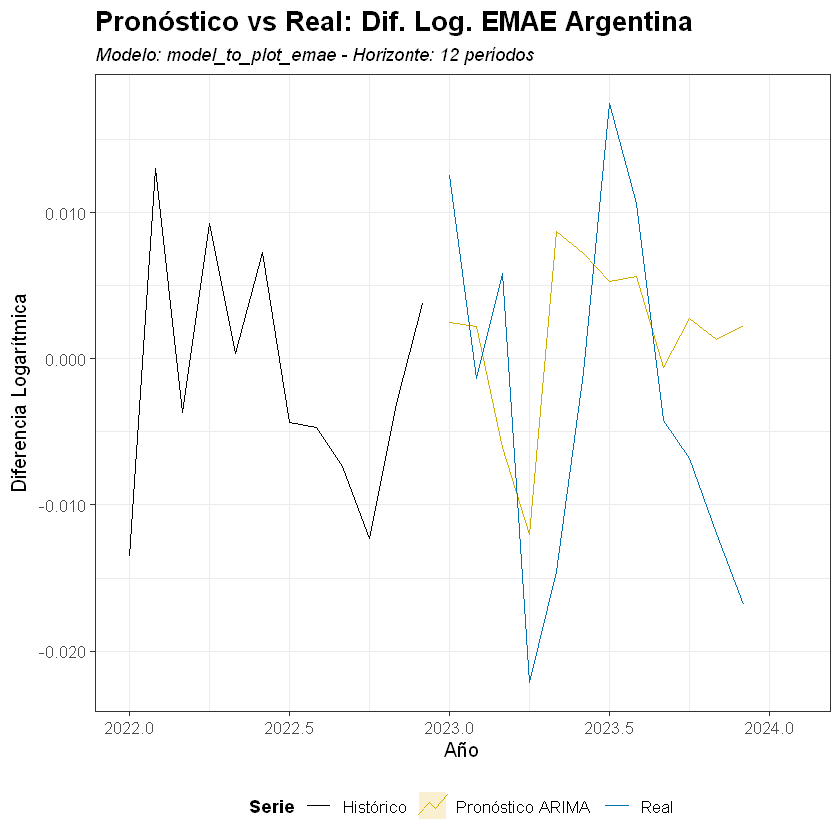

In [49]:
# --- Graficar Pronóstico EMAE Argentina vs Real usando función modular ---

# 1. Cargar la función desde el script R
# Asegurarse de que el archivo plot_forecast_comparison.R esté en el mismo directorio o ruta correcta.
source("plot_forecast_comparison.R")

# 2. Definir parámetros para el gráfico
h_forecast_emae <- 12                   # Horizonte ya definido
model_to_plot_emae <- model_emae_arg    # Modelo ARIMA ajustado (forzado)
original_ts_emae <- dl_emae             # Serie original completa (diferencias log)
title_emae <- "Dif. Log. EMAE Argentina" # Título para el gráfico
start_plot_emae <- 2022                 # Año desde donde mostrar histórico
ylabel_emae <- "Diferencia Logarítmica" # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
# Se usa el modelo 'model_emae_arg' que ahora contiene la estructura forzada.
plot_emae_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_emae,
  original_ts = original_ts_emae,
  h = h_forecast_emae,
  series_title = title_emae,
  start_year_plot = start_plot_emae,
  ylab_text = ylabel_emae,
  show_pi = FALSE # No mostrar Intervalos de Predicción por ahora
)

# 4. Mostrar el gráfico generado
print(plot_emae_comparison)

# 5. (Opcional) Guardar el gráfico con dimensiones y resolución específicas
# Se recomienda crear una carpeta 'graficos' si no existe.
# dir.create("graficos", showWarnings = FALSE)
# ggsave(
#   "graficos/pronostico_emae_comparacion_forzado.png", # Nombre de archivo
#   plot = plot_emae_comparison,
#   width = 10,  # Ancho en pulgadas (más ancho que alto)
#   height = 6,  # Alto en pulgadas
#   dpi = 300    # Resolución
# )

### 4.2 Proyeccion IPC - Argentina

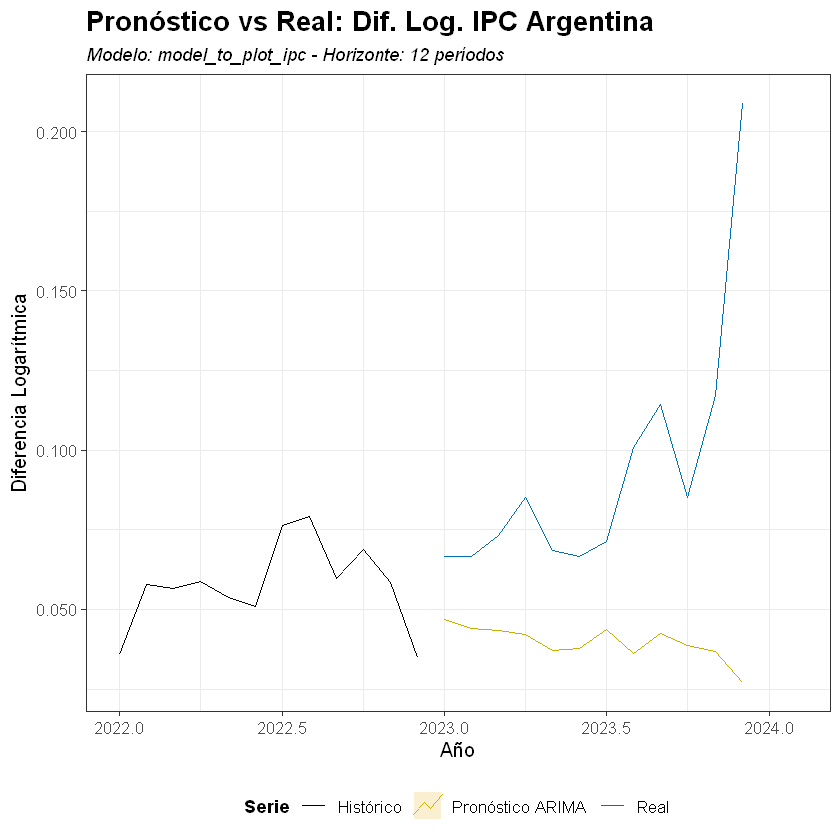

In [50]:
# --- Graficar Pronóstico IPC Argentina vs Real usando función modular ---

# 1. Cargar la función desde el script R (si no se ha hecho antes en la sesión)
# source("plot_forecast_comparison.R")

# 2. Definir parámetros específicos para el gráfico del IPC
h_forecast_ipc <- 12                   # Horizonte
model_to_plot_ipc <- model_ipc_arg     # Modelo ARIMA ajustado (forzado o auto.arima)
original_ts_ipc <- dl_ipc_arg          # Serie original completa (diferencias log)
title_ipc <- "Dif. Log. IPC Argentina" # Título para el gráfico
start_plot_ipc <- 2022                 # Año desde donde mostrar histórico
ylabel_ipc <- "Diferencia Logarítmica" # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
# Se usa el modelo actual 'model_ipc_arg'.
plot_ipc_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_ipc,
  original_ts = original_ts_ipc,
  h = h_forecast_ipc,
  series_title = title_ipc,
  start_year_plot = start_plot_ipc,
  ylab_text = ylabel_ipc,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
print(plot_ipc_comparison)

# 5. (Opcional) Guardar el gráfico con dimensiones y resolución específicas
# DESCOMENTA para guardar la imagen.
# dir.create("graficos", showWarnings = FALSE)
# ggsave(
#   filename = "graficos/pronostico_ipc_arg_comparacion.png", # Nombre de archivo
#   plot = plot_ipc_comparison,
#   width = 10,  # Ancho
#   height = 6,  # Alto
#   dpi = 300    # Resolución
# )
# print("Gráfico guardado en graficos/pronostico_ipc_arg_comparacion.png")

### 4.3 Proyeccion Agregado Monetario M2 - Argentina

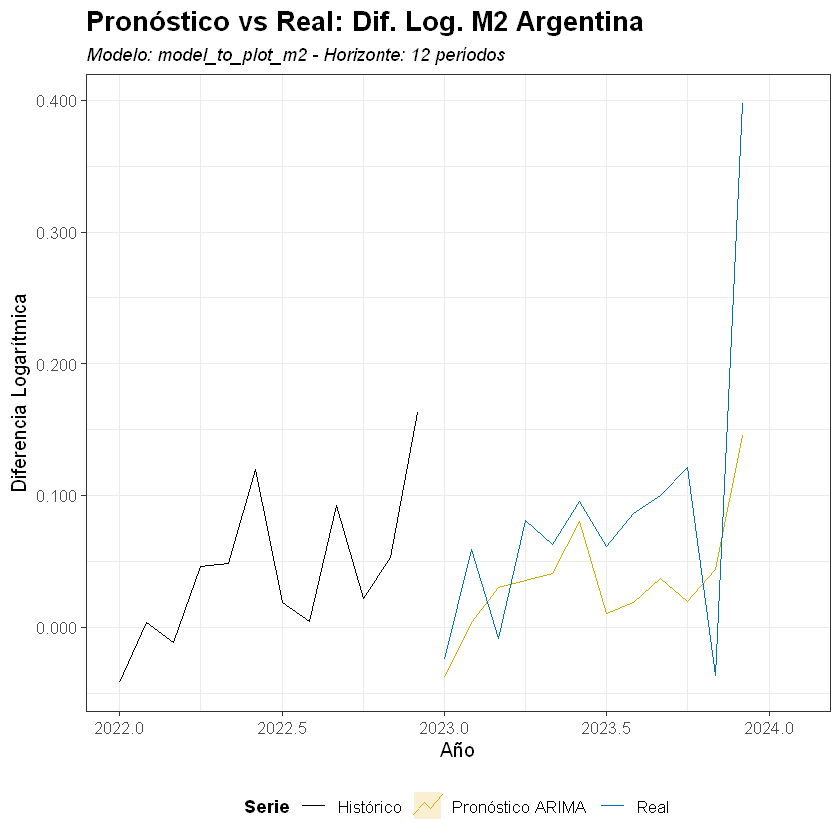

In [51]:
# --- Graficar Pronóstico M2 Argentina vs Real usando función modular ---

# 1. Cargar la función desde el script R (si no se ha hecho antes)
# source("plot_forecast_comparison.R")

# 2. Definir parámetros específicos para el gráfico del M2
h_forecast_m2 <- 12                   # Horizonte
model_to_plot_m2 <- model_m2_arg      # Modelo ARIMA ajustado
original_ts_m2 <- dl_m2_arg           # Serie original completa (diferencias log)
title_m2 <- "Dif. Log. M2 Argentina"  # Título para el gráfico
start_plot_m2 <- 2022                 # Año desde donde mostrar histórico
ylabel_m2 <- "Diferencia Logarítmica" # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
plot_m2_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_m2,
  original_ts = original_ts_m2,
  h = h_forecast_m2,
  series_title = title_m2,
  start_year_plot = start_plot_m2,
  ylab_text = ylabel_m2,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
print(plot_m2_comparison)

# 5. (Opcional) Guardar el gráfico con dimensiones y resolución específicas
# DESCOMENTA para guardar la imagen.
# dir.create("graficos", showWarnings = FALSE)
# ggsave(
#   filename = "graficos/pronostico_m2_arg_comparacion.png", # Nombre de archivo
#   plot = plot_m2_comparison,
#   width = 10,  # Ancho
#   height = 6,  # Alto
#   dpi = 300    # Resolución
# )
# print("Gráfico guardado en graficos/pronostico_m2_arg_comparacion.png")

### 4.4 Proyeccion Tasa de interes - Argentina

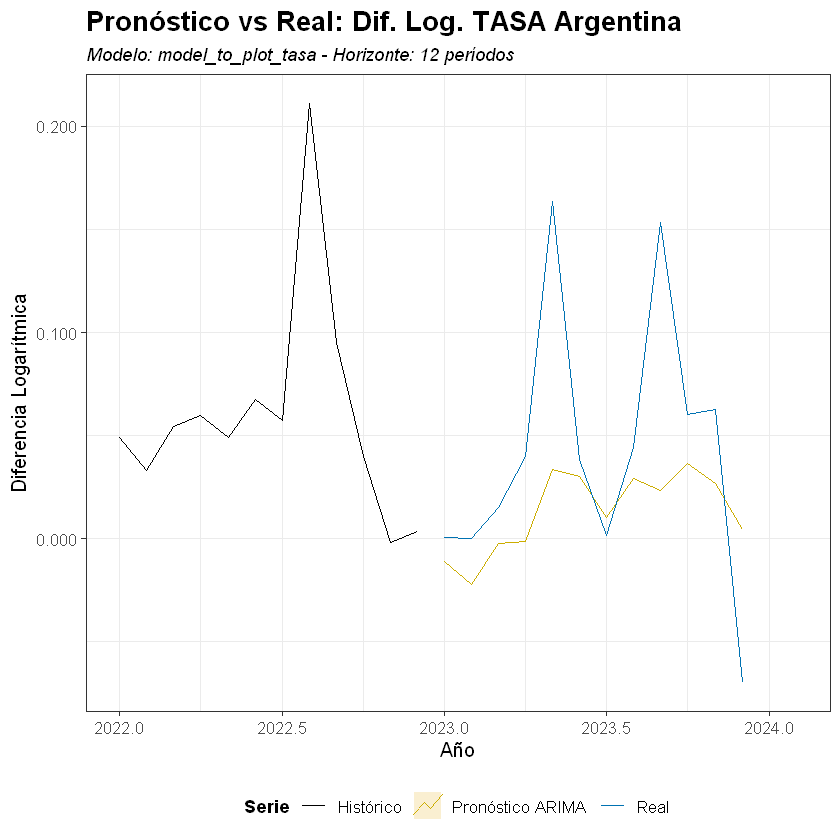

In [52]:
# --- Graficar Pronóstico TASA Argentina vs Real usando función modular ---

# 1. Cargar la función desde el script R (si no se ha hecho antes)
# source("plot_forecast_comparison.R")

# 2. Definir parámetros específicos para el gráfico de la TASA
h_forecast_tasa <- 12                     # Horizonte
model_to_plot_tasa <- model_tasa_arg      # Modelo ARIMA ajustado (forzado o auto.arima)
original_ts_tasa <- dl_tasa_arg           # Serie original completa (diferencias log)
title_tasa <- "Dif. Log. TASA Argentina"  # Título para el gráfico
start_plot_tasa <- 2022                   # Año desde donde mostrar histórico
ylabel_tasa <- "Diferencia Logarítmica"   # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
# Se usa el modelo actual 'model_tasa_arg'.
plot_tasa_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_tasa,
  original_ts = original_ts_tasa,
  h = h_forecast_tasa,
  series_title = title_tasa,
  start_year_plot = start_plot_tasa,
  ylab_text = ylabel_tasa,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
print(plot_tasa_comparison)

# 5. (Opcional) Guardar el gráfico con dimensiones y resolución específicas
# DESCOMENTA para guardar la imagen.
# dir.create("graficos", showWarnings = FALSE)
# ggsave(
#   filename = "graficos/pronostico_tasa_arg_comparacion.png", # Nombre de archivo
#   plot = plot_tasa_comparison,
#   width = 10,  # Ancho
#   height = 6,  # Alto
#   dpi = 300    # Resolución
# )
# print("Gráfico guardado en graficos/pronostico_tasa_arg_comparacion.png")


## Chile

### 4.5 Proyeccion IMACEC - Chile

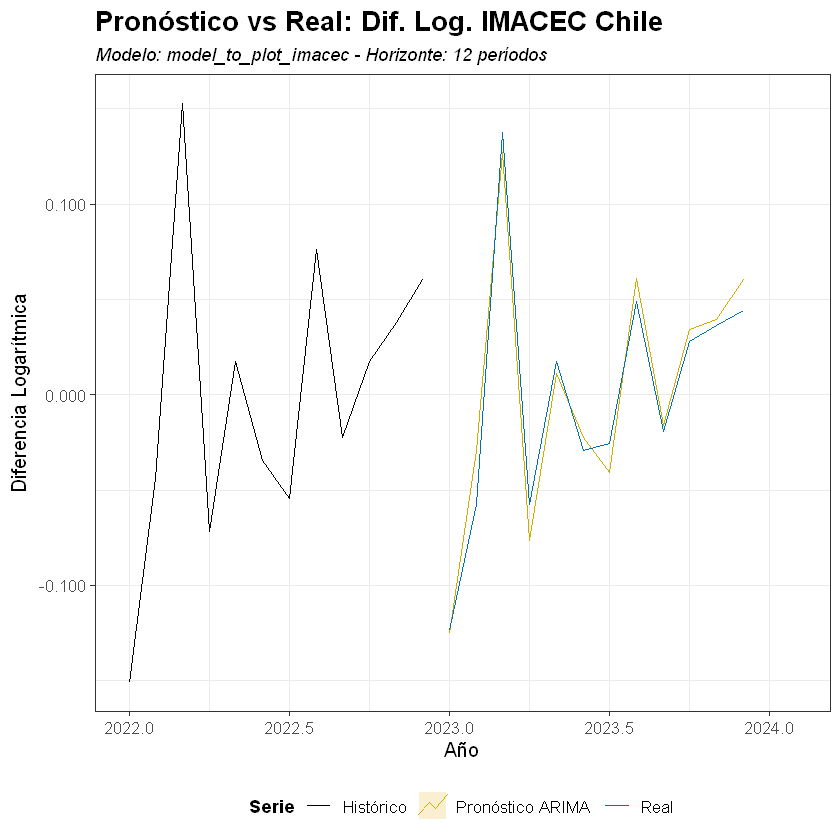

In [53]:
# --- Pronóstico IMACEC Chile con el nuevo modelo simplificado ---
library(forecast)
library(lubridate)

# Modelo ARIMA simplificado sin regresores externos
h_forecast_imacec    <- 12
model_to_plot_imacec <- model_imacec_chi
original_ts_imacec   <- dl_imacec
title_imacec         <- "Dif. Log. IMACEC Chile"
start_plot_imacec    <- 2022
ylabel_imacec        <- "Diferencia Logarítmica"

# Utilizar la función modular directamente sin complicaciones
plot_imacec_comparison <- plot_forecast_vs_actual(
  model           = model_to_plot_imacec,
  original_ts     = original_ts_imacec,
  h               = h_forecast_imacec,
  series_title    = title_imacec,
  start_year_plot = start_plot_imacec,
  ylab_text       = ylabel_imacec,
  show_pi         = FALSE
)

# Mostrar el gráfico
print(plot_imacec_comparison)

### 4.6 Proyeccion IPC - Chile

Warning message in forecast.forecast_ARIMA(model, h = h, level = pi_level, xreg = as.matrix(xreg)):
"xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order."


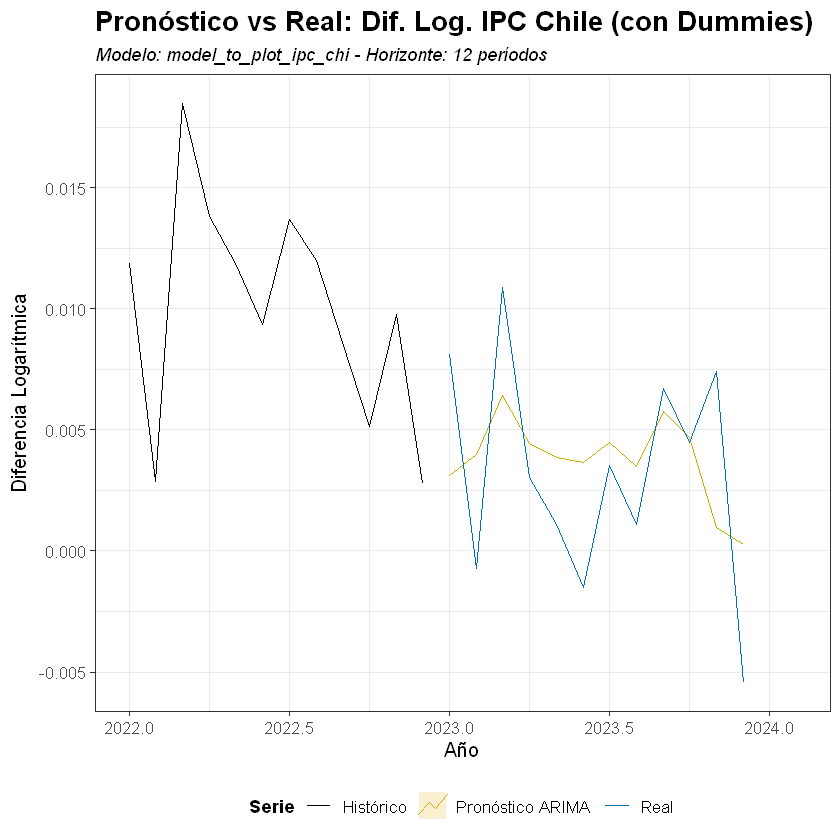

In [54]:
# --- Graficar Pronóstico IPC Chile (con Regresores) vs Real usando función modular ---

# 1. Cargar la función desde el script R (asegúrate que esté actualizada con el parámetro xreg)
# source("plot_forecast_comparison.R")

# 2. Definir parámetros para el gráfico del IPC Chile
h_forecast_ipc_chi <- 12                    # Horizonte
model_to_plot_ipc_chi <- model_ipc_chi_reg  # Modelo ARIMAX ajustado
original_ts_ipc_chi <- dl_ipc_chi           # Serie original completa (diferencias log)
title_ipc_chi <- "Dif. Log. IPC Chile (con Dummies)" # Título para el gráfico
start_plot_ipc_chi <- 2022                  # Año desde donde mostrar histórico
ylabel_ipc_chi <- "Diferencia Logarítmica"  # Etiqueta eje Y

# 3. Crear los regresores (dummies mensuales) para el período de pronóstico
#    (Este código es necesario antes de llamar a la función)
#    Necesitamos las dummies para Ene-2023 a Dic-2023
future_time_seq_ipc <- seq(as.Date("2023-01-01"), by = "month", length.out = h_forecast_ipc_chi)
future_ts_ipc <- ts(1:h_forecast_ipc_chi, start=c(2023,1), frequency=12)
future_mes_ipc <- factor(cycle(future_ts_ipc), levels = 1:12)
# Generar la matriz de dummies futuras, excluyendo el intercepto
xreg_forecast_ipc_chi <- model.matrix(~ future_mes_ipc)[, -1]

# 4. Llamar a la función para generar el objeto ggplot, pasando xreg
plot_ipc_chi_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_ipc_chi,
  original_ts = original_ts_ipc_chi,
  h = h_forecast_ipc_chi,
  series_title = title_ipc_chi,
  start_year_plot = start_plot_ipc_chi,
  ylab_text = ylabel_ipc_chi,
  show_pi = FALSE, # No mostrar Intervalos de Predicción
  xreg = xreg_forecast_ipc_chi # <-- Pasamos los regresores futuros aquí
)

# 5. Mostrar el gráfico generado
print(plot_ipc_chi_comparison)

# 6. (Opcional) Guardar el gráfico con dimensiones y resolución específicas
# DESCOMENTA para guardar la imagen.
# dir.create("graficos", showWarnings = FALSE)
# ggsave(
#   filename = "graficos/pronostico_ipc_chi_reg_comparacion.png", # Nombre de archivo
#   plot = plot_ipc_chi_comparison,
#   width = 10,  # Ancho
#   height = 6,  # Alto
#   dpi = 300    # Resolución
# )
# print("Gráfico guardado en graficos/pronostico_ipc_chi_reg_comparacion.png")


### 4.6 Proyeccion Agregado Monetario M2 - Chile

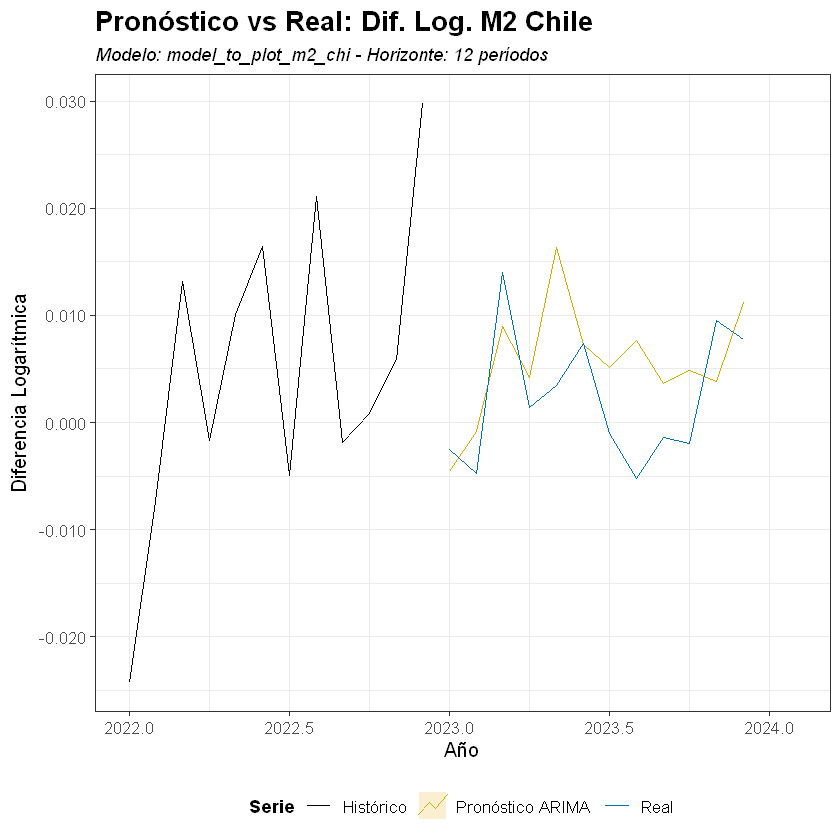

In [55]:
# --- Graficar Pronóstico M2 Chile vs Real usando función modular ---

# 1. Cargar la función desde el script R (si no se ha hecho antes)
# source("plot_forecast_comparison.R")

# 2. Definir parámetros específicos para el gráfico del M2 Chile
h_forecast_m2_chi <- 12                   # Horizonte (asumido)
model_to_plot_m2_chi <- model_m2_chi      # Modelo ARIMA ajustado
original_ts_m2_chi <- dl_m2_chi           # Serie original completa (diferencias log)
title_m2_chi <- "Dif. Log. M2 Chile"      # Título para el gráfico
start_plot_m2_chi <- 2022                 # Año desde donde mostrar histórico
ylabel_m2_chi <- "Diferencia Logarítmica" # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
plot_m2_chi_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_m2_chi,
  original_ts = original_ts_m2_chi,
  h = h_forecast_m2_chi,
  series_title = title_m2_chi,
  start_year_plot = start_plot_m2_chi,
  ylab_text = ylabel_m2_chi,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
print(plot_m2_chi_comparison)

# 5. (Opcional) Guardar el gráfico con dimensiones y resolución específicas
# DESCOMENTA para guardar la imagen.
# dir.create("graficos", showWarnings = FALSE)
# ggsave(
#   filename = "graficos/pronostico_m2_chi_comparacion.png", # Nombre de archivo
#   plot = plot_m2_chi_comparison,
#   width = 10,  # Ancho
#   height = 6,  # Alto
#   dpi = 300    # Resolución
# )
# print("Gráfico guardado en graficos/pronostico_m2_chi_comparacion.png")


### 4.7 Proyeccion Diferencia Logaritmica de Tasa de Interes - Chile

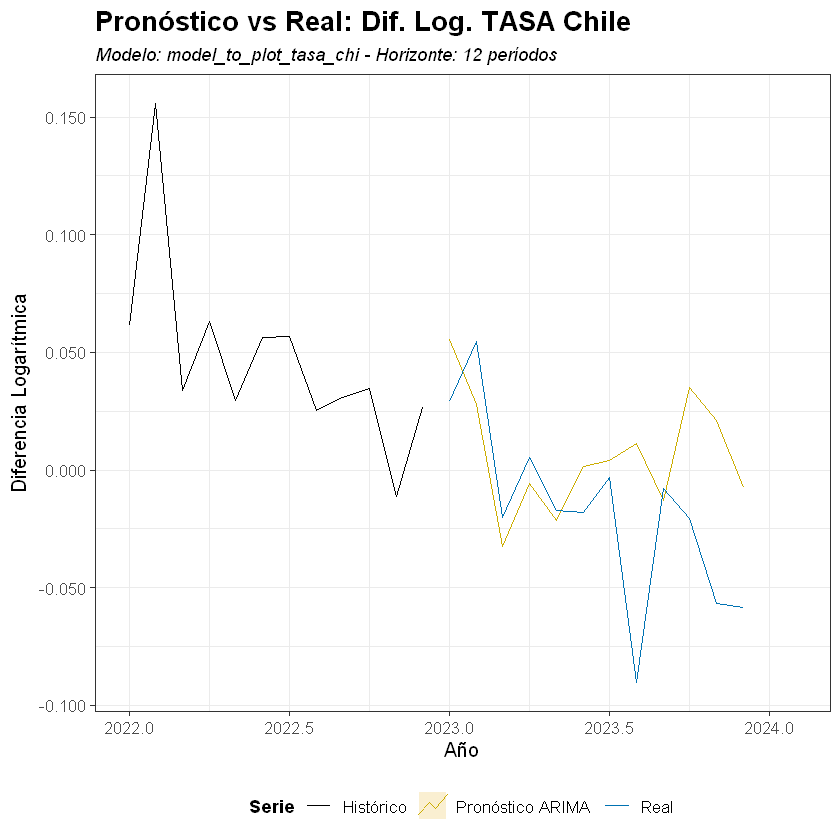

In [56]:
# --- Graficar Pronóstico TASA Chile vs Real usando función modular ---

# 1. Cargar la función desde el script R (si no se ha hecho antes)
# source("plot_forecast_comparison.R")

# 2. Definir parámetros específicos para el gráfico de la TASA Chile
h_forecast_tasa_chi <- 12                     # Horizonte
model_to_plot_tasa_chi <- model_tasa_chi      # Modelo ARIMA ajustado (forzado o auto.arima)
original_ts_tasa_chi <- dl_tasa_chi           # Serie original completa (diferencias log)
title_tasa_chi <- "Dif. Log. TASA Chile"      # Título para el gráfico
start_plot_tasa_chi <- 2022                   # Año desde donde mostrar histórico
ylabel_tasa_chi <- "Diferencia Logarítmica"   # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
# Se usa el modelo actual 'model_tasa_chi'. No se pasa xreg.
plot_tasa_chi_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_tasa_chi,
  original_ts = original_ts_tasa_chi,
  h = h_forecast_tasa_chi,
  series_title = title_tasa_chi,
  start_year_plot = start_plot_tasa_chi,
  ylab_text = ylabel_tasa_chi,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
print(plot_tasa_chi_comparison)

# 5. (Opcional) Guardar el gráfico con dimensiones y resolución específicas
# DESCOMENTA para guardar la imagen.
# dir.create("graficos", showWarnings = FALSE)
# ggsave(
#   filename = "graficos/pronostico_tasa_chi_comparacion.png", # Nombre de archivo
#   plot = plot_tasa_chi_comparison,
#   width = 10,  # Ancho
#   height = 6,  # Alto
#   dpi = 300    # Resolución
# )
# print("Gráfico guardado en graficos/pronostico_tasa_chi_comparacion.png")


# 5 - Comparacion y evaluacion de proyecciones

## 5.1 Comparacion y evaluacion de modelos argentinos

In [57]:
# Cargar eval_pron.R
source("eval_pron.R")

In [58]:
# --- Evaluación de Pronósticos ARGENTINA en Niveles (2023) ---

# 1. Cargar la función de evaluación (si no está cargada)
# source("eval_pron.R")

# 2. Definir horizonte y período de evaluación (común)
h_eval <- 12
start_eval <- c(2023, 1)
end_eval <- c(2023, 12)

# 3. Lista para almacenar los resultados de evaluación de Argentina
results_list_arg <- list()

# 4. Función auxiliar para retransformar (si no está definida antes)
#    Se define aquí por si se ejecuta la celda de forma independiente
retransform_diflog_forecast <- function(fc_object, original_level_ts) {
  # Último valor real LOGARÍTMICO antes del pronóstico
  last_log_real_obj <- tryCatch({
      log(window(original_level_ts, end = time(fc_object$x)[length(fc_object$x)]))[length(fc_object$x)]
  }, error = function(e) { NULL }) # Manejo de error si no hay datos pre-pronóstico

  if(is.null(last_log_real_obj)) {
      stop("No se pudo obtener el último valor real pre-pronóstico para retransformar.")
  }
  last_log_real <- last_log_real_obj
  
  # Suma acumulada de las diferencias logarítmicas pronosticadas
  cumulative_log_diff <- cumsum(fc_object$mean)
  
  # Calcular los pronósticos logarítmicos sumando el último valor real log
  log_forecast_levels <- last_log_real + cumulative_log_diff
  
  # Retransformar a niveles exponenciando
  forecast_levels <- exp(log_forecast_levels)
  
  return(forecast_levels) # Devuelve un objeto ts
}


# --- Procesamiento y Evaluación Series ARGENTINAS ---

# Configuración solo para Argentina
series_config_arg <- list(
  list(name="EMAE Arg", model=model_emae_arg, original_ts=ts_emae,     xreg=NULL),
  list(name="IPC Arg",  model=model_ipc_arg,  original_ts=ts_ipc_arg,  xreg=NULL),
  list(name="M2 Arg",   model=model_m2_arg,   original_ts=ts_m2_arg,   xreg=NULL),
  list(name="TASA Arg", model=model_tasa_arg, original_ts=ts_tasa_arg, xreg=NULL)
)

# Bucle para series argentinas
for (cfg in series_config_arg) {
  cat("Procesando ARG:", cfg$name, "\n")
  
  # Generar pronóstico de diferencias logarítmicas
  fc_diflog <- tryCatch({
      forecast(cfg$model, h = h_eval) # No se necesita xreg para Arg
  }, error = function(e) {
      warning(paste("Error al pronosticar para", cfg$name, ":", e$message)); return(NULL) })
  if (is.null(fc_diflog)) next

  # Retransformar a niveles
  forecast_levels <- tryCatch({
      retransform_diflog_forecast(fc_diflog, cfg$original_ts)
  }, error = function(e) {
      warning(paste("Error al retransformar para", cfg$name, ":", e$message)); return(NULL) })
  if (is.null(forecast_levels)) next
  
  # Obtener valores reales en niveles
  actual_levels <- window(cfg$original_ts, start = start_eval, end = end_eval)
  
  # Preparar vectores y validar longitudes
  Y_P <- as.vector(forecast_levels)
  Y_A <- as.vector(actual_levels)
  if (length(Y_A) == 0) { warning(paste("No hay datos reales para", cfg$name)); next }
  min_len <- min(length(Y_P), length(Y_A))
  if (min_len < h_eval) { warning(paste("Datos incompletos en", cfg$name)) }
  Y_P <- Y_P[1:min_len]; Y_A <- Y_A[1:min_len]

  # Evaluar
  evaluation_metrics <- tryCatch({
      Eval_Pron(Y_P = Y_P, Y_A = Y_A, Nombre = cfg$name)
  }, error = function(e) {
      warning(paste("Error en Eval_Pron para", cfg$name, ":", e$message)); return(NULL) })
  if(is.null(evaluation_metrics)) next
  
  results_list_arg[[cfg$name]] <- evaluation_metrics
  cat("Evaluación ARG completada para:", cfg$name, "\n\n")
}

# Consolidar y mostrar resultados de Argentina
if (length(results_list_arg) > 0) {
  final_results_table_arg <- do.call(cbind, results_list_arg)
  print("--- Tabla Evaluación ARGENTINA (Niveles 2023) ---")
  print(round(final_results_table_arg, 4))
} else { print("No se generaron resultados para Argentina.") }


Procesando ARG: EMAE Arg 
Evaluación ARG completada para: EMAE Arg 

Procesando ARG: IPC Arg 
Evaluación ARG completada para: IPC Arg 

Procesando ARG: M2 Arg 
Evaluación ARG completada para: M2 Arg 

Procesando ARG: TASA Arg 
Evaluación ARG completada para: TASA Arg 

[1] "--- Tabla Evaluación ARGENTINA (Niveles 2023) ---"
             EMAE Arg   IPC Arg          M2 Arg TASA Arg
RMSE           2.9673 8230.1438 7752755472.0833  26.1101
MAE            2.4110 6180.9268 6303945443.5654  21.3069
MAPE           1.6478   22.8985         29.4289  19.2593
U_Theil        0.0100    0.2025          0.2331   0.1459
U_sesgo        0.1065    0.5640          0.6612   0.6659
U_varianza     0.0672    0.4161          0.3298   0.3247
U_covarianza   0.8263    0.0199          0.0090   0.0094


## 5.2 Comparacion y evaluacion de modelos chilenos


In [61]:
# --- Evaluación de Pronósticos CHILE en Niveles (2023) - Corregido para el Modelo Simplificado ---

# Cargar librerías necesarias
library(forecast)
library(lubridate)

# Verificar existencia de funciones requeridas
if (!exists("Eval_Pron")) stop("Función Eval_Pron no encontrada.")
if (!exists("retransform_diflog_forecast")) stop("Función retransform_diflog_forecast no encontrada.")

# 1. Lista para almacenar los resultados
results_list_chi <- list()

# 2. Parámetros comunes
if (!exists("h_eval")) h_eval <- 12
if (!exists("start_eval")) start_eval <- c(2023, 1)
if (!exists("end_eval")) end_eval <- c(2023, 12)

# --- Configuración y Bucle para Series Chilenas ---
series_config_chi <- list(
  # CORREGIDO: El modelo simplificado ya no necesita regresores externos (needs_xreg_future=FALSE)
  list(name="IMACEC Chi", model=model_imacec_chi, original_ts=ts_imacec, needs_xreg_future=FALSE),
  list(name="IPC Chi",  model=model_ipc_chi_reg, original_ts=ts_ipc_chi,  needs_xreg_future=TRUE),
  list(name="M2 Chi",   model=model_m2_chi,   original_ts=ts_m2_chi,   needs_xreg_future=FALSE),
  list(name="TASA Chi", model=model_tasa_chi, original_ts=ts_tasa_chi, needs_xreg_future=FALSE)
)

# Bucle principal
for (cfg in series_config_chi) {
  cat("Procesando Evaluación para:", cfg$name, "...\n")
  xreg_future <- NULL # Inicializar

  if (cfg$needs_xreg_future) {
    if (cfg$name == "IPC Chi") {
        # Generación específica para IPC (dummies mensuales)
        future_ts <- ts(1:h_eval, start=start_eval, frequency=12)
        future_mes <- factor(cycle(future_ts), levels = 1:12)
        xreg_future <- model.matrix(~ future_mes)[, -1]
    }
  } # Fin if (cfg$needs_xreg_future)

  # Generar pronóstico (diflog)
  fc_diflog <- tryCatch({
      if (cfg$needs_xreg_future) {
          forecast(cfg$model, h = h_eval, xreg = xreg_future)
      } else {
          forecast(cfg$model, h = h_eval) # Sin xreg para modelos que no lo necesitan
      }
  }, error = function(e) {
      warning(paste("Error en forecast() para", cfg$name, ":", e$message)); return(NULL)
  })
  if (is.null(fc_diflog)) next

  # Retransformar a niveles
  forecast_levels <- tryCatch({
      retransform_diflog_forecast(fc_diflog, cfg$original_ts)
  }, error = function(e) {
      warning(paste("Error en retransform_diflog_forecast() para", cfg$name, ":", e$message)); return(NULL)
  })
  if (is.null(forecast_levels)) next

  # Obtener valores reales
  actual_levels <- window(cfg$original_ts, start = start_eval, end = end_eval)

  # Validar y preparar vectores
  Y_P <- as.vector(forecast_levels); Y_A <- as.vector(actual_levels)
  if (length(Y_A) == 0) { warning(paste("No hay datos reales para", cfg$name, "en", start_eval[1])); next }
  min_len <- min(length(Y_P), length(Y_A))
  if (min_len < h_eval) { warning(paste("Longitudes inconsistentes para", cfg$name, ". Usando", min_len, "puntos.")) }
  Y_P <- Y_P[1:min_len]; Y_A <- Y_A[1:min_len]

  # Evaluar pronóstico
  evaluation_metrics <- tryCatch({
      Eval_Pron(Y_P = Y_P, Y_A = Y_A, Nombre = cfg$name)
  }, error = function(e) {
      warning(paste("Error en Eval_Pron() para", cfg$name, ":", e$message)); return(NULL)
  })
  if(is.null(evaluation_metrics)) next

  # Almacenar resultados
  results_list_chi[[cfg$name]] <- evaluation_metrics
  cat(" -> Evaluación completada.\n")

} # Fin bucle for

# Consolidar y mostrar resultados finales
if (length(results_list_chi) > 0) {
  final_results_table_chi <- do.call(cbind, results_list_chi)
  print("--- Tabla Evaluación CHILE (Niveles 2023) ---")
  print(round(final_results_table_chi, 4))
} else {
  print("No se generaron resultados de evaluación para Chile.")
}

Procesando Evaluación para: IMACEC Chi ...
 -> Evaluación completada.
Procesando Evaluación para: IPC Chi ...


Warning message in forecast.forecast_ARIMA(cfg$model, h = h_eval, xreg = xreg_future):
"xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order."


 -> Evaluación completada.
Procesando Evaluación para: M2 Chi ...
 -> Evaluación completada.
Procesando Evaluación para: TASA Chi ...
 -> Evaluación completada.
[1] "--- Tabla Evaluación CHILE (Niveles 2023) ---"
             IMACEC Chi IPC Chi    M2 Chi TASA Chi
RMSE             6.0827  0.4674 3555.1105   1.5704
MAE              5.9612  0.4291 3073.6619   1.1808
MAPE             5.5382  0.4314    1.7252   8.4784
U_Theil          0.0289  0.0023    0.0100   0.0510
U_sesgo          0.9604  0.0176    0.2748   0.1304
U_varianza       0.0028  0.4676    0.5402   0.3814
U_covarianza     0.0368  0.5148    0.1850   0.4881


# 6. Comparación con Suavizado Exponencial (ETS) sin Tendencia

## 6.1 Comparacion ETS Argentina

In [60]:
# --- Ajuste, Pronóstico y Evaluación ARGENTINA con ETS (Sin Tendencia) ---

# 1. Cargar paquetes y funciones necesarias (si no están cargados)
# library(forecast)
# source("eval_pron.R") # Asegurarse que Eval_Pron esté disponible

# 2. Definir períodos y horizonte
end_train_ets <- c(2022, 12)
start_eval_ets <- c(2023, 1)
end_eval_ets <- c(2023, 12)
h_ets <- 12

# 3. Lista para almacenar resultados de evaluación ETS para Argentina
results_list_ets_arg <- list()

# 4. Configuración de las series ARGENTINAS (usando las series originales en NIVELES)
series_config_ets_arg <- list(
  list(name="EMAE Arg",   original_ts=ts_emae),
  list(name="IPC Arg",    original_ts=ts_ipc_arg),
  list(name="M2 Arg",     original_ts=ts_m2_arg),
  list(name="TASA Arg",   original_ts=ts_tasa_arg)
)

# --- Bucle para Ajuste, Pronóstico y Evaluación ETS (Solo Argentina) ---
cat("--- Iniciando Proceso ETS (trend='N') para ARGENTINA ---\n")
for (cfg in series_config_ets_arg) {
  cat("Procesando ETS para:", cfg$name, "\n")
  
  # Extraer datos de entrenamiento (NIVELES)
  training_ts <- window(cfg$original_ts, end = end_train_ets)
  
  # Validar si hay datos suficientes
  if(length(training_ts) < 2 * frequency(training_ts)) { 
       warning(paste("Datos insuficientes para ETS en", cfg$name,". Saltando."))
       next
  }

  # Ajustar modelo ETS (Sin Tendencia, Error/Seasonality automáticos)
  ets_model <- tryCatch({
    ets(training_ts, trend = "N", allow.multiplicative.trend = FALSE) 
  }, error = function(e) {
    warning(paste("Error al ajustar ETS para", cfg$name, ":", e$message)); return(NULL) 
  })
  
  if (is.null(ets_model)) {
      cat("  AJUSTE ETS FALLÓ para", cfg$name, "- No se puede continuar.\n\n")
      next 
  }
  
  cat("  Modelo ETS ajustado:", ets_model$method, "\n")
  
  # Generar pronóstico ETS
  ets_forecast <- tryCatch({
    forecast(ets_model, h = h_ets)
  }, error = function(e) {
    warning(paste("Error al pronosticar ETS para", cfg$name, ":", e$message)); return(NULL)
  })
  
  if (is.null(ets_forecast)) next 

  # Obtener pronóstico medio (Y_P) y valores reales (Y_A)
  Y_P_ets <- as.vector(ets_forecast$mean)
  actual_levels_eval <- window(cfg$original_ts, start = start_eval_ets, end = end_eval_ets)
  Y_A_ets <- as.vector(actual_levels_eval)
  
  # Validar longitudes
  if (length(Y_A_ets) == 0) { warning(paste("No hay datos reales 2023 para", cfg$name)); next }
  min_len_ets <- min(length(Y_P_ets), length(Y_A_ets))
  if (min_len_ets < h_ets) { warning(paste("Datos incompletos ETS en", cfg$name)) }
  Y_P_ets <- Y_P_ets[1:min_len_ets]; Y_A_ets <- Y_A_ets[1:min_len_ets]

  # Evaluar usando Eval_Pron
  evaluation_metrics_ets <- tryCatch({
      Eval_Pron(Y_P = Y_P_ets, Y_A = Y_A_ets, Nombre = paste(cfg$name, "(ETS)"))
  }, error = function(e) {
      warning(paste("Error en Eval_Pron para ETS", cfg$name, ":", e$message)); return(NULL) })
      
  if(is.null(evaluation_metrics_ets)) next 
  
  # Guardar resultados
  results_list_ets_arg[[cfg$name]] <- evaluation_metrics_ets
  
  cat("  Evaluación ETS completada para:", cfg$name, "\n\n")
}
cat("--- Proceso ETS para ARGENTINA Finalizado ---\n\n")

# 5. Consolidar y mostrar resultados ETS de Argentina
if (length(results_list_ets_arg) > 0) {
  final_results_table_ets_arg <- do.call(cbind, results_list_ets_arg)
  print("--- Tabla Resumen Evaluación Pronósticos ETS ARGENTINA (trend='N') (Niveles 2023) ---")
   # Renombrar columna si solo queda una
   if (ncol(final_results_table_ets_arg) == 1 && length(results_list_ets_arg) == 1) {
       colnames(final_results_table_ets_arg) <- names(results_list_ets_arg)
   }
  print(round(final_results_table_ets_arg, 4)) 
} else {
  print("No se generaron resultados de evaluación ETS válidos para Argentina.")
}


--- Iniciando Proceso ETS (trend='N') para ARGENTINA ---
Procesando ETS para: EMAE Arg 


Warning message in value[[3L]](cond):
"Error al ajustar ETS para EMAE Arg : No model able to be fitted"


  AJUSTE ETS FALLÓ para EMAE Arg - No se puede continuar.

Procesando ETS para: IPC Arg 


Warning message in value[[3L]](cond):
"Error al ajustar ETS para IPC Arg : No model able to be fitted"


  AJUSTE ETS FALLÓ para IPC Arg - No se puede continuar.

Procesando ETS para: M2 Arg 


Warning message in value[[3L]](cond):
"Error al ajustar ETS para M2 Arg : No model able to be fitted"


  AJUSTE ETS FALLÓ para M2 Arg - No se puede continuar.

Procesando ETS para: TASA Arg 


Warning message in value[[3L]](cond):
"Error al ajustar ETS para TASA Arg : No model able to be fitted"


  AJUSTE ETS FALLÓ para TASA Arg - No se puede continuar.

--- Proceso ETS para ARGENTINA Finalizado ---

[1] "No se generaron resultados de evaluación ETS válidos para Argentina."
